In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import joblib
#import 

In [300]:
sub = pd.read_csv("datasets/submission.csv")
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

In [301]:
izmir_ilce = pd.read_html('https://www.nufusu.com/ilceleri/izmir-ilceleri-nufusu')[0]
manisa_ilce = pd.read_html('http://www.manisa.gov.tr/nufus-ve-dagilim')[0].iloc[:-1,:]
izmir_ilce=izmir_ilce[['İlçe','Toplam Nüfus']].rename(columns={'İlçe':'İLÇE','Toplam Nüfus':'ilce_nufus'})
manisa_ilce=manisa_ilce[['İlçe','İlçe Nüfusu']].rename(columns={'İlçe':'İLÇE','İlçe Nüfusu':'ilce_nufus'})
ilce_nufus=pd.concat([izmir_ilce,manisa_ilce])
ilce_nufus['İLÇE']=ilce_nufus['İLÇE'].apply(unidecode).str.lower()

In [302]:
train['İL'] = train['İL'].apply(unidecode).str.lower()
train['İLÇE'] = train['İLÇE'].apply(unidecode).str.lower()

In [303]:
train=pd.merge(train,ilce_nufus,on=['İLÇE'],how='left')

In [304]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(train)

##################### Shape #####################
(105392, 30)
##################### Types #####################
KESİNTİ_NO                             int64
İL                                    object
İLÇE                                  object
ŞEBEKE_UNSURU                         object
ŞEBEKE_UNSURU_KODU                    object
KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA     object
KAYNAĞA_GÖRE                          object
SÜREYE_GÖRE                           object
SEBEBE_GÖRE                           object
BİLDİRİME_GÖRE                        object
BAŞLAMA_TARİHİ_VE_ZAMANI              object
SONA_ERME_TARİHİ_VE_ZAMANI            object
KESİNTİ_SÜRESİ                       float64
KENTSEL_OG                             int64
KENTSEL_AG                             int64
KENTALTI_OG                            int64
KENTALTI_AG                            int64
KIRSAL_OG                              int64
KIRSAL_AG                              int64
TOPLAM_KENTSEL_OG               

In [305]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != "O"]
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].dtype == "O" and dataframe[col].nunique() > car_th]

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].dtype != "O" and dataframe[col].nunique() < cat_th]

    num_cols = num_cols + cat_but_car
    num_cols = [col for col in num_cols if col not in num_but_cat]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return num_cols, cat_cols, cat_but_car

num_cols, cat_cols, cat_but_car = grab_col_names(train)

Observations: 105392
Variables: 30
cat_cols: 8
num_cols: 22
cat_but_car: 6
num_but_cat: 2


In [306]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean().sort_values()}), end="\n\n\n")

<AxesSubplot:>

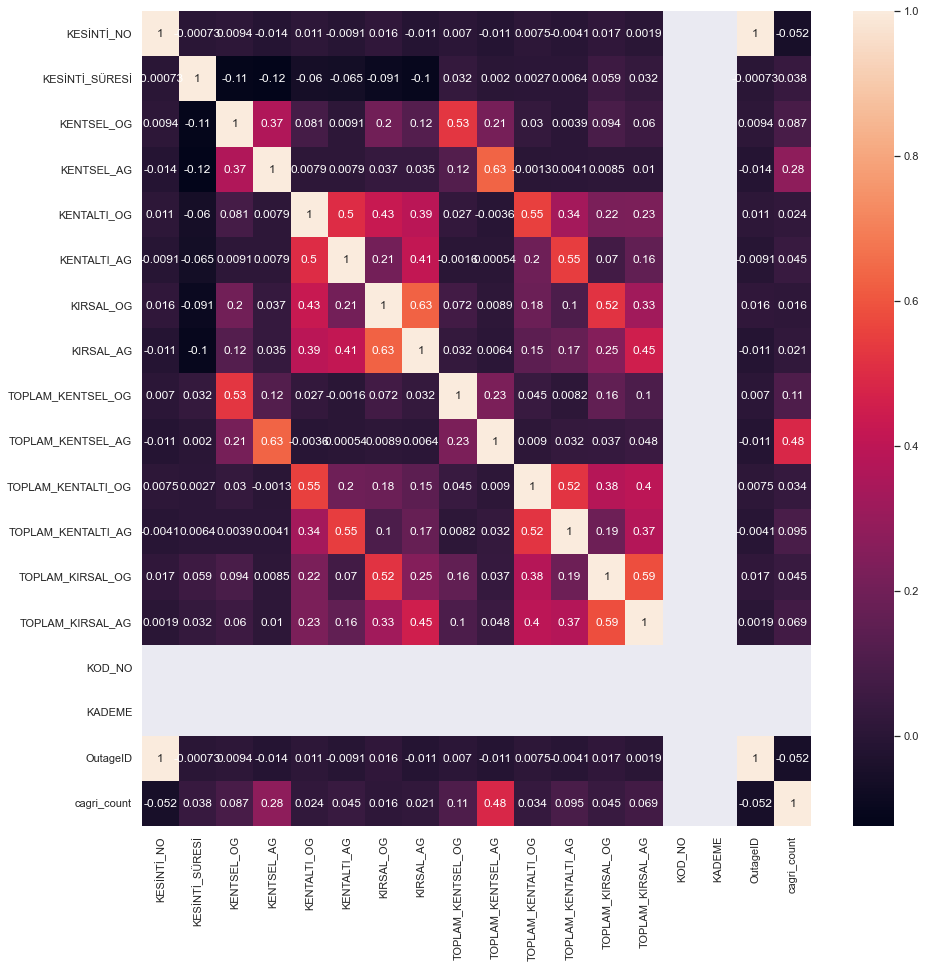

In [307]:
corr = train.corr()
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(corr,annot=True)


In [308]:
train.drop(["KOD_NO","KADEME"],axis=1,inplace=True)

In [309]:
train["ilce_nufus"] = train["ilce_nufus"].astype(float)

In [310]:
train["BAŞLAMA_TARİHİ_VE_ZAMANI"] = pd.to_datetime(train["BAŞLAMA_TARİHİ_VE_ZAMANI"],dayfirst=True)
train["SONA_ERME_TARİHİ_VE_ZAMANI"] = pd.to_datetime(train["SONA_ERME_TARİHİ_VE_ZAMANI"],dayfirst=True)

In [311]:
train["baslama_hour"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.hour
train["baslama_day"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.day
train["baslama_dayofweek"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.dayofweek
train["baslama_dayofyear"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.dayofyear
train["baslama_week"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.week
train["baslama_month"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.month


train["bitis_hour"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.hour
train["bitis_day"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.day
train["bitis_dayofweek"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.dayofweek
train["bitis_dayofyear"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.dayofyear
train["bitis_week"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.week
train["bitis_month"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.month



C:\Users\talha\AppData\Local\Temp\ipykernel_6268\1591688405.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train["baslama_week"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.week
C:\Users\talha\AppData\Local\Temp\ipykernel_6268\1591688405.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train["bitis_week"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.week


In [312]:
zeros = train.set_index("BAŞLAMA_TARİHİ_VE_ZAMANI").resample("D")["cagri_count"].sum()

In [313]:
zeros = pd.DataFrame(zeros)

In [314]:
zeros[zeros["cagri_count"] == 0]

,cagri_count
BAŞLAMA_TARİHİ_VE_ZAMANI,
2022-03-24,0.0
2022-03-25,0.0
2022-03-26,0.0
2022-03-27,0.0
2022-03-28,0.0
...,...
2022-06-08,0.0
2022-06-09,0.0
2022-06-10,0.0


In [315]:
train = train[train["BAŞLAMA_TARİHİ_VE_ZAMANI"] < "2022-03-24"]

<AxesSubplot:xlabel='BAŞLAMA_TARİHİ_VE_ZAMANI'>

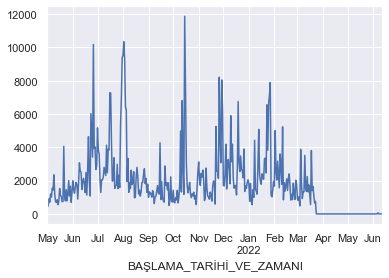

In [316]:
train.set_index("BAŞLAMA_TARİHİ_VE_ZAMANI").resample("D")["cagri_count"].sum().plot()

In [317]:
train["ŞEBEKE_UNSURU"].unique()

array(['OG Fideri', 'TM Fideri', 'KÖK', 'DM', 'Dağıtım Transformatörü',
       'Saha Dağıtım Kutusu (SDK)', 'AG Fideri', 'Abone Tesisi'],
      dtype=object)

In [318]:
target_summary_with_cat(train,"cagri_count","ŞEBEKE_UNSURU") #RARE ENCODING YAPILACAK

                           TARGET_MEAN
ŞEBEKE_UNSURU                         
Abone Tesisi                  1.284722
AG Fideri                     5.653978
Saha Dağıtım Kutusu (SDK)     7.857778
KÖK                           8.296250
Dağıtım Transformatörü        8.522039
OG Fideri                    12.446668
DM                           15.280012
TM Fideri                    44.704758




<AxesSubplot:xlabel='ŞEBEKE_UNSURU', ylabel='cagri_count'>

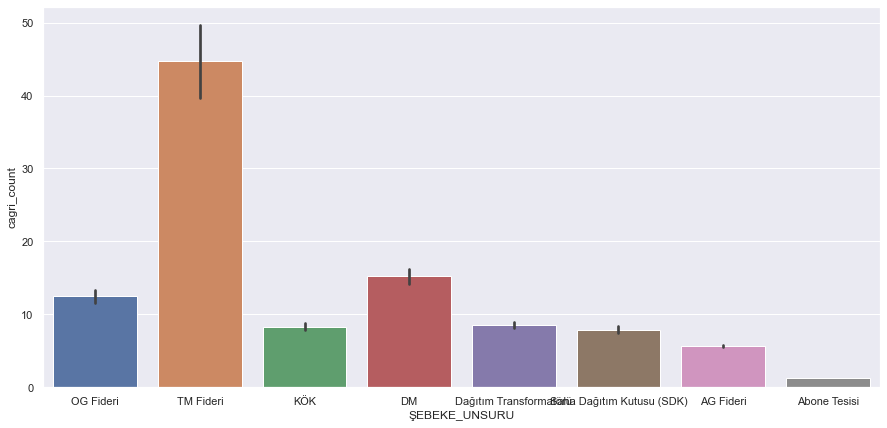

In [319]:
fig,ax = plt.subplots(figsize=(15,7))
sns.barplot(data=train,x="ŞEBEKE_UNSURU",y="cagri_count")

In [320]:
train.drop("ŞEBEKE_UNSURU_KODU",axis=1,inplace=True)

In [321]:
train.drop("İLÇE", axis=1, inplace=True)

In [322]:
train.drop("KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA",axis=1,inplace=True)

In [323]:
train["KAYNAĞA_GÖRE"].unique()

array(['Dağıtım-OG', 'Dağıtım-AG', 'İletim'], dtype=object)

In [324]:
target_summary_with_cat(train,"cagri_count","KAYNAĞA_GÖRE")

              TARGET_MEAN
KAYNAĞA_GÖRE             
Dağıtım-AG       3.939661
Dağıtım-OG      14.345516
İletim          35.641953




<AxesSubplot:xlabel='KAYNAĞA_GÖRE', ylabel='cagri_count'>

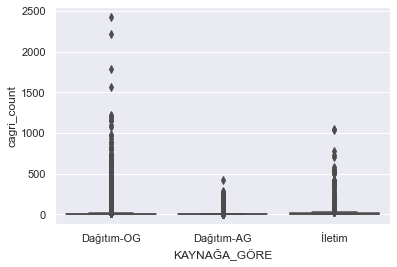

In [325]:
sns.boxplot(data=train,x="KAYNAĞA_GÖRE",y="cagri_count") #KORELASYON VAR SİLMİYORUM

In [326]:
train["SÜREYE_GÖRE"].unique()

array(['Uzun', 'Kısa'], dtype=object)

In [327]:
target_summary_with_cat(train,"cagri_count","SÜREYE_GÖRE")

             TARGET_MEAN
SÜREYE_GÖRE             
Kısa            0.032642
Uzun            7.415965




In [328]:
train["SEBEBE_GÖRE"].unique()

array(['Şebeke işletmecisi', 'Dışsal', 'Güvenlik', '0'], dtype=object)

In [329]:
target_summary_with_cat(train,"cagri_count","SEBEBE_GÖRE")

                    TARGET_MEAN
SEBEBE_GÖRE                    
0                      0.000000
Şebeke işletmecisi     6.837317
Dışsal                23.987893
Güvenlik              42.925234




In [330]:
train["BİLDİRİME_GÖRE"].unique()

array(['Bildirimsiz'], dtype=object)

In [331]:
train.drop("BİLDİRİME_GÖRE",axis=1,inplace=True)

In [332]:
train.drop(["BAŞLAMA_TARİHİ_VE_ZAMANI","SONA_ERME_TARİHİ_VE_ZAMANI"],axis=1,inplace=True)

In [333]:
train.loc[train["SÜREYE_GÖRE"]=="Kısa","KESİNTİ_SÜRESİ"].mean()

0.016094342092145674

In [334]:
train.loc[train["SÜREYE_GÖRE"]=="Uzun","KESİNTİ_SÜRESİ"].mean()

2.44149772494469

In [335]:
train[train["KESİNTİ_SÜRESİ"] < 0 ]

,KESİNTİ_NO,İL,ŞEBEKE_UNSURU,KAYNAĞA_GÖRE,SÜREYE_GÖRE,SEBEBE_GÖRE,BAŞLAMA_TARİHİ_VE_ZAMANI,SONA_ERME_TARİHİ_VE_ZAMANI,KESİNTİ_SÜRESİ,KENTSEL_OG,...,baslama_dayofweek,baslama_dayofyear,baslama_week,baslama_month,bitis_hour,bitis_day,bitis_dayofweek,bitis_dayofyear,bitis_week,bitis_month
8707,2310569,manisa,DM,Dağıtım-OG,Kısa,Şebeke işletmecisi,2022-06-04 18:10:28,2022-06-04 15:12:42,-2.962778,0,...,5,155,22,6,15,4,5,155,22,6
17682,2308730,manisa,OG Fideri,Dağıtım-OG,Kısa,Şebeke işletmecisi,2022-06-02 12:07:16,2022-06-02 10:16:03,-1.853611,4,...,3,153,22,6,10,2,3,153,22,6


In [336]:
train["KESİNTİ_SÜRESİ"].min()

-2.962777777

In [337]:
train["OutageID"].nunique()

105392

In [338]:
train.drop("OutageID",axis=1,inplace=True)

In [339]:
train["KESİNTİ_NO"].nunique()

105392

In [340]:
train.drop("KESİNTİ_NO",axis=1, inplace=True)

In [341]:
def outlier_thresholds(dataframe, col_name,q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 -quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit,up_limit


def check_outlier(dataframe,col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [342]:
num_cols, cat_cols, cat_but_car = grab_col_names(train)

Observations: 105392
Variables: 34
cat_cols: 7
num_cols: 27
cat_but_car: 0
num_but_cat: 2


for col in num_cols:

    replace_with_thresholds(train,col)

KESİNTİ_SÜRESİ


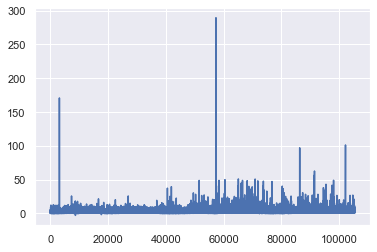

KENTSEL_OG


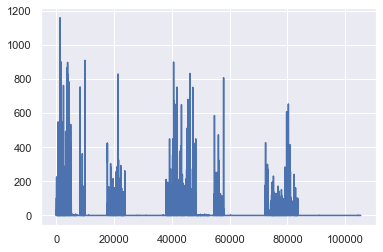

KENTSEL_AG


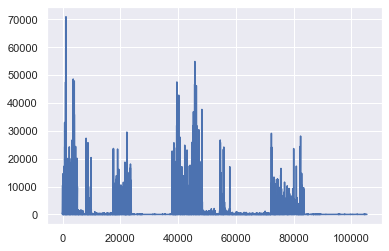

KENTALTI_OG


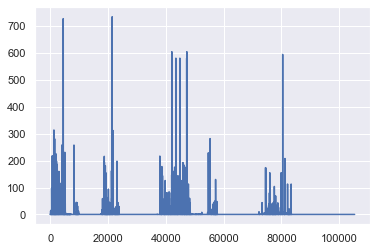

KENTALTI_AG


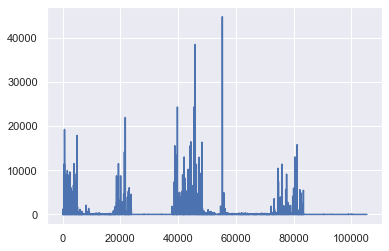

KIRSAL_OG


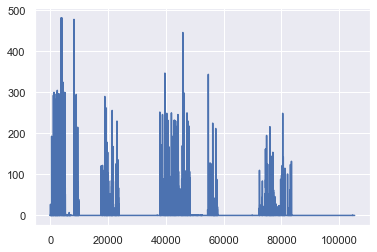

KIRSAL_AG


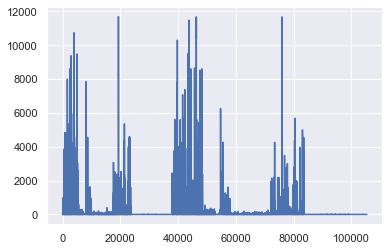

TOPLAM_KENTSEL_OG


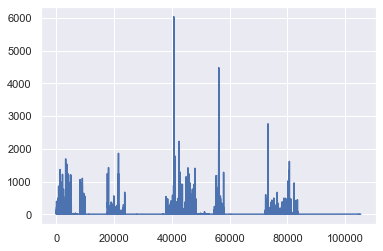

TOPLAM_KENTSEL_AG


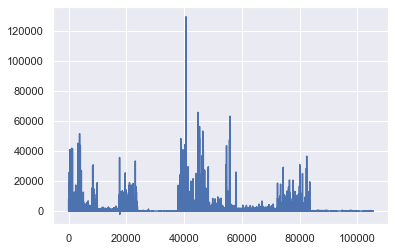

TOPLAM_KENTALTI_OG


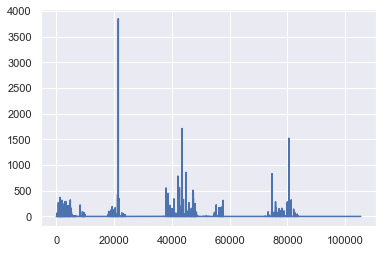

TOPLAM_KENTALTI_AG


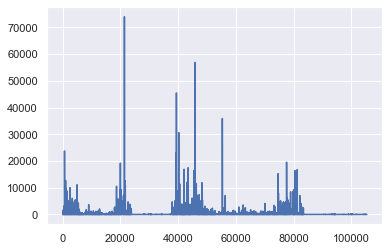

TOPLAM_KIRSAL_OG


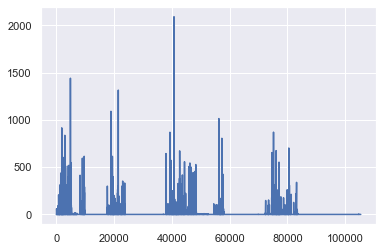

TOPLAM_KIRSAL_AG


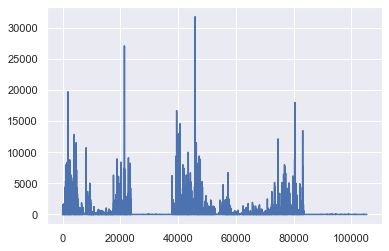

cagri_count


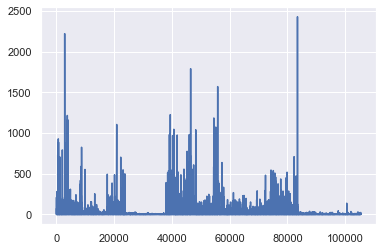

ilce_nufus


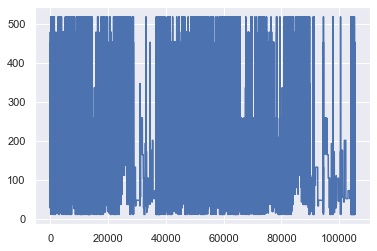

baslama_hour


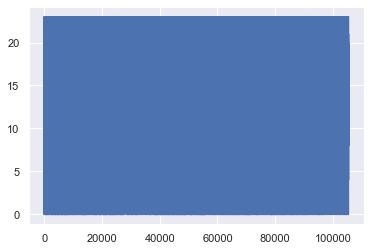

baslama_day


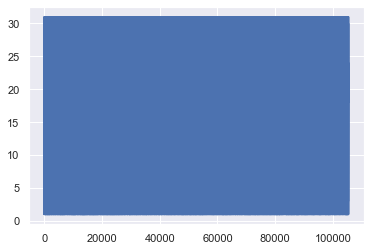

baslama_dayofyear


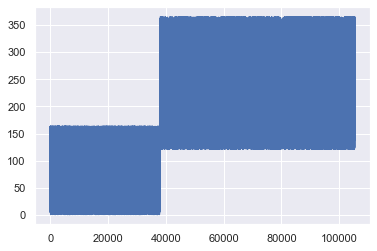

baslama_week


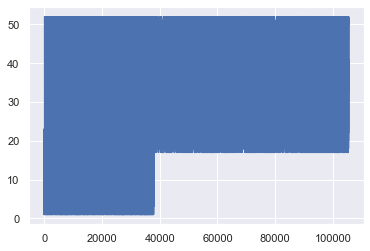

baslama_month


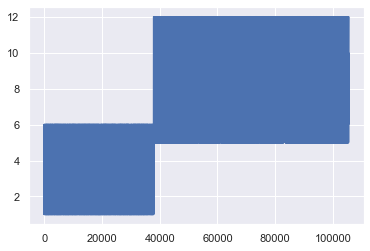

bitis_hour


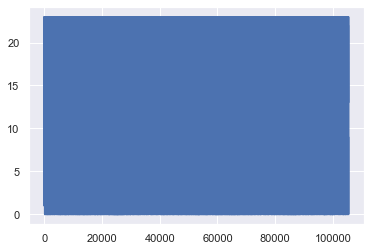

bitis_day


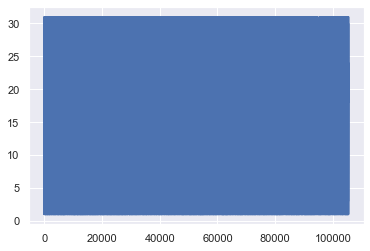

bitis_dayofyear


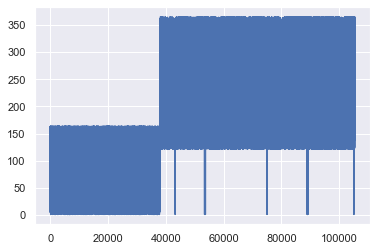

bitis_week


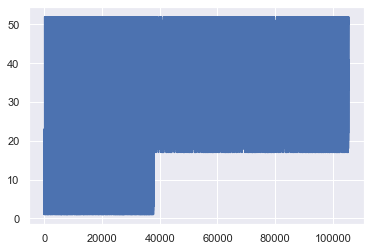

bitis_month


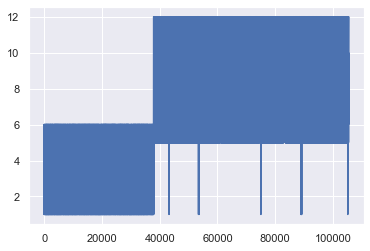

In [297]:
for col in num_cols:

    train[col].plot()
    print(col)
    plt.show(block=True)

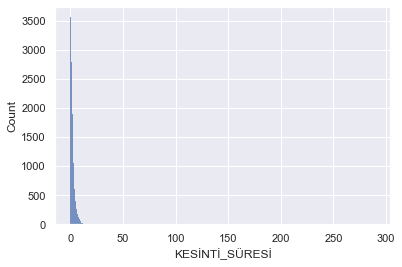

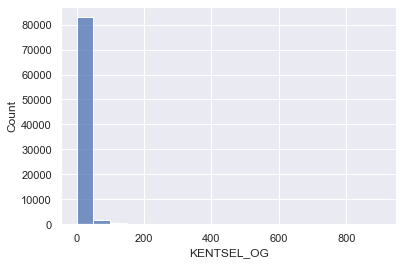

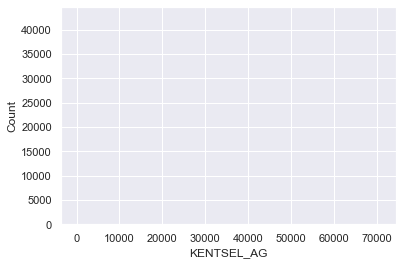

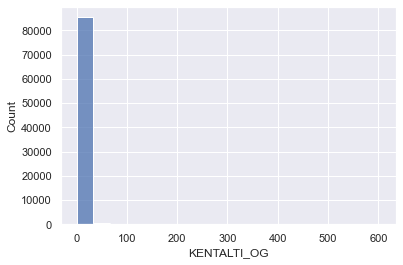

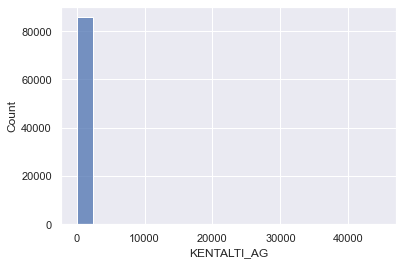

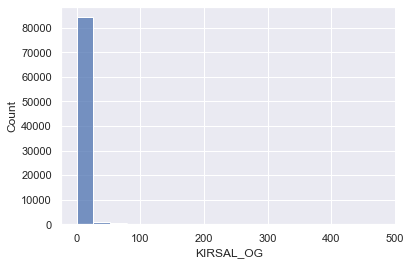

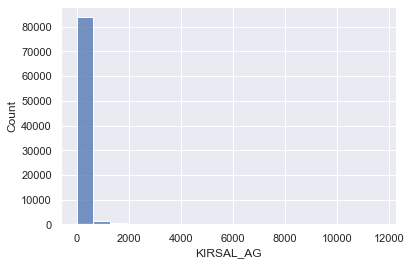

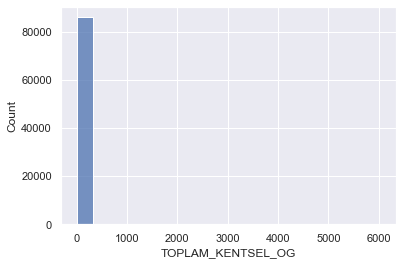

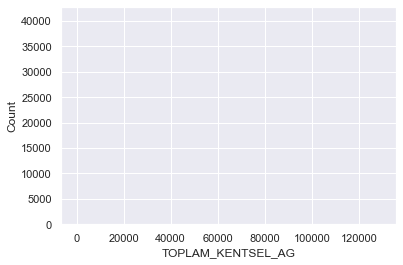

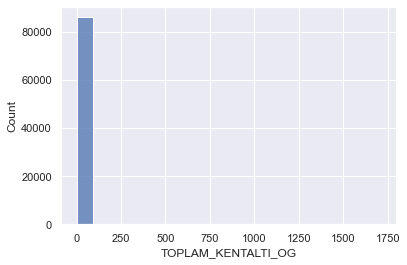

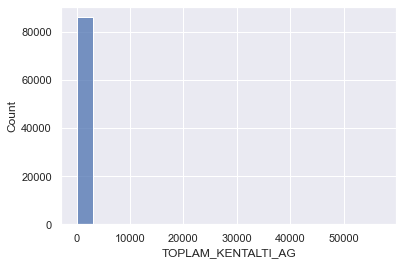

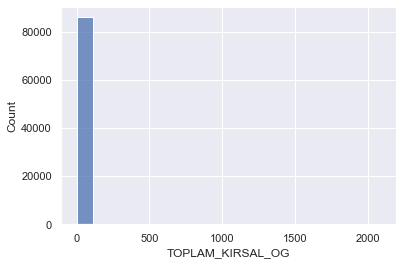

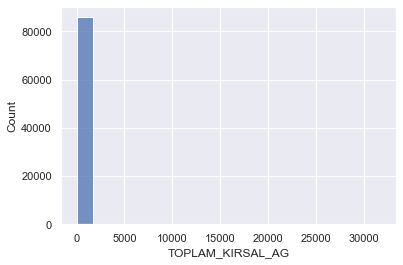

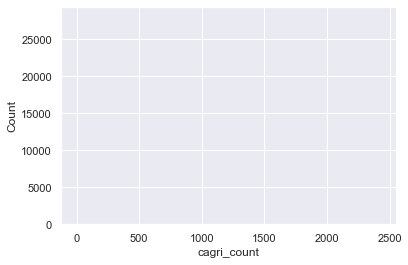

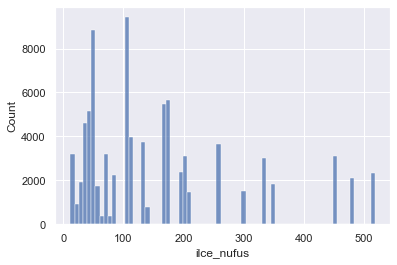

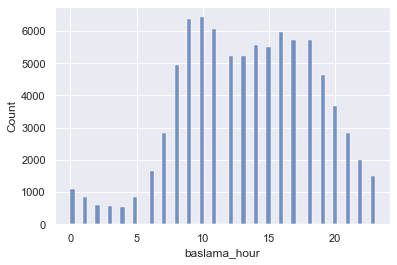

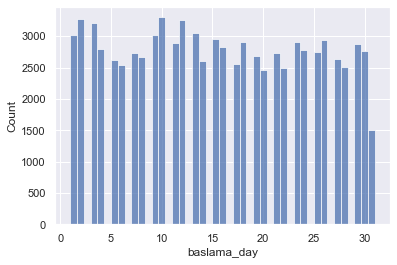

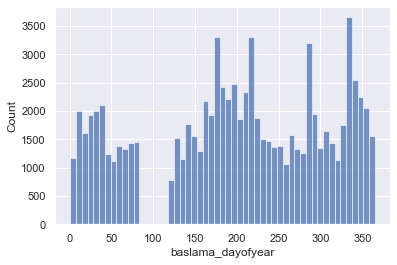

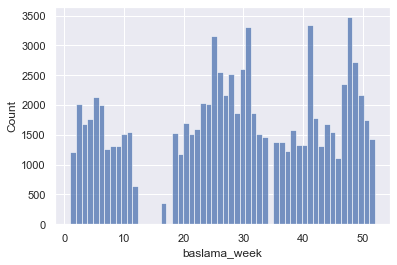

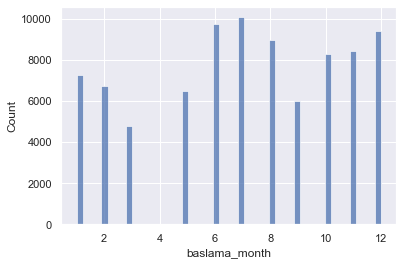

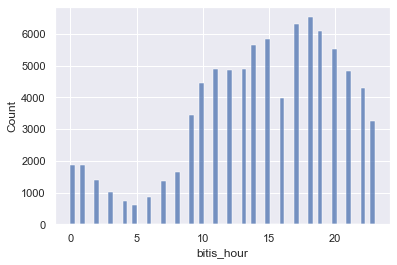

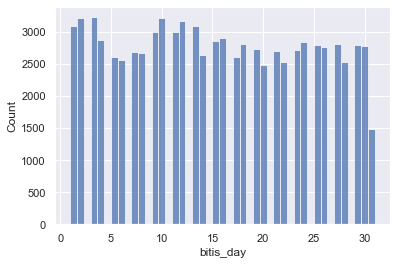

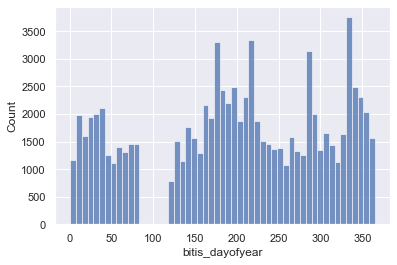

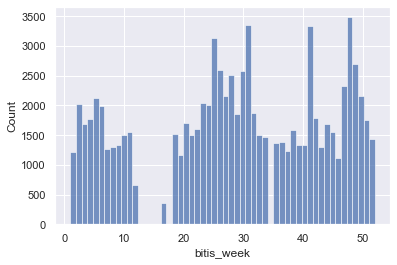

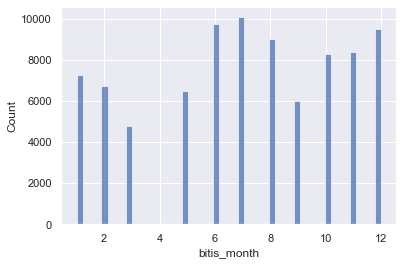

In [248]:
for col in num_cols:
    sns.histplot(data=train, x=col)
    plt.show(block=True)

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


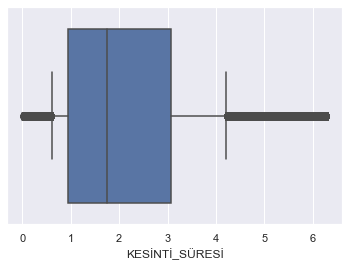

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


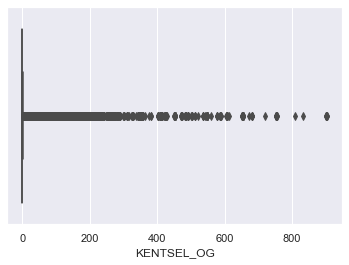

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


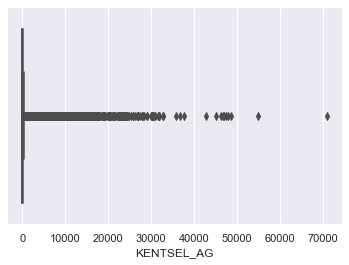

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


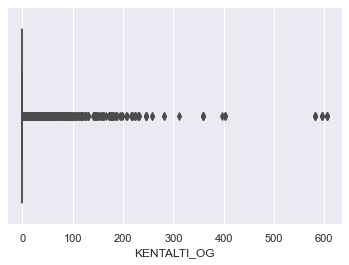

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


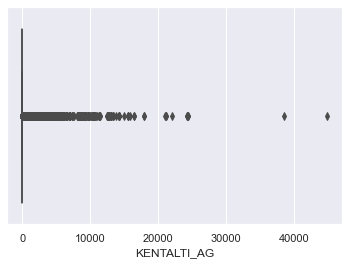

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


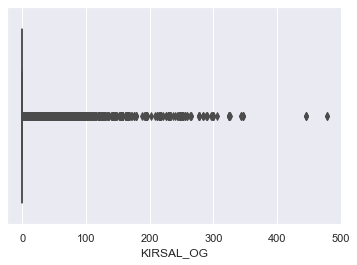

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


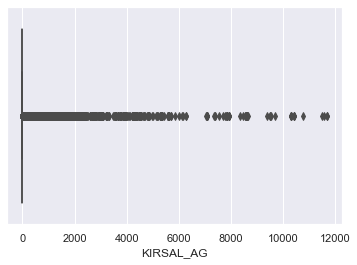

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


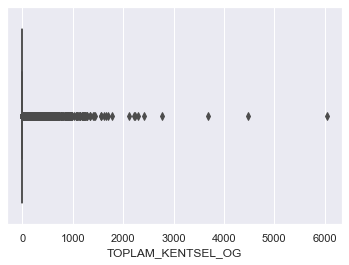

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


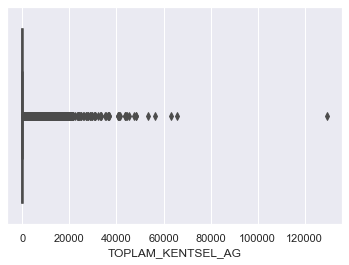

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


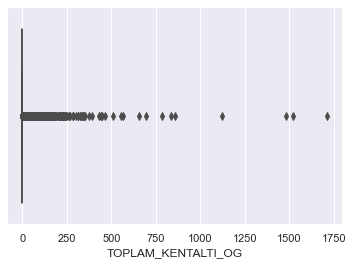

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


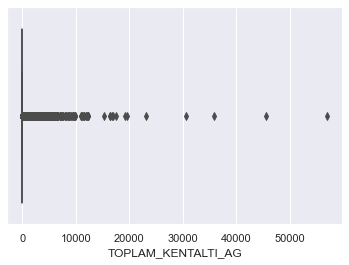

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


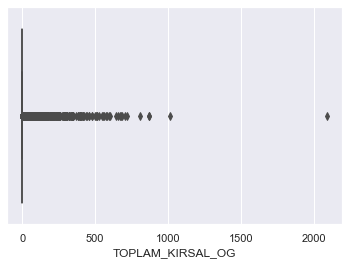

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


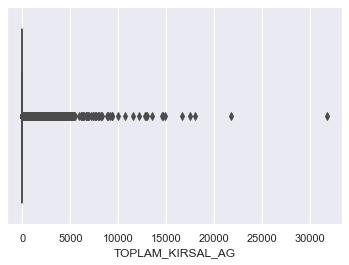

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


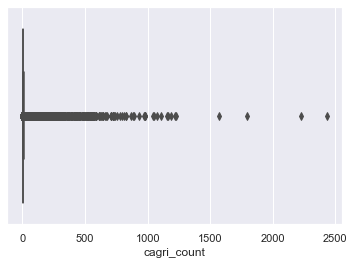

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


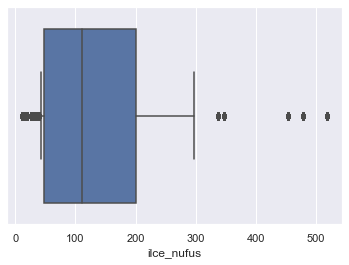

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


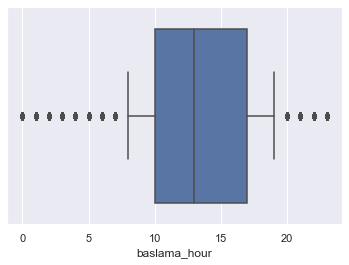

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


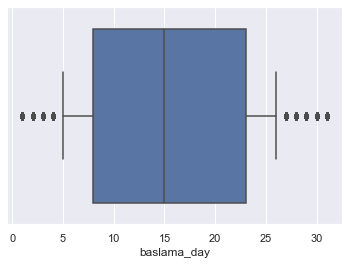

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


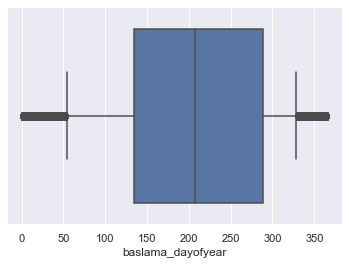

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


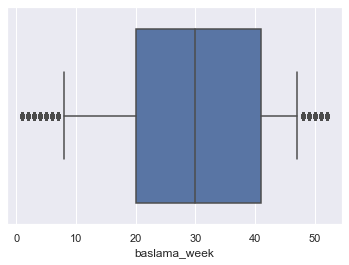

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


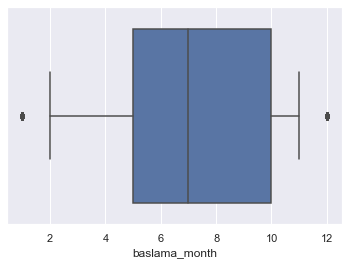

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


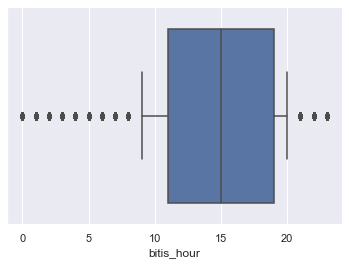

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


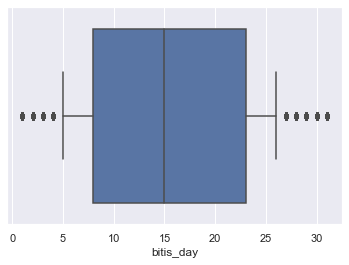

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


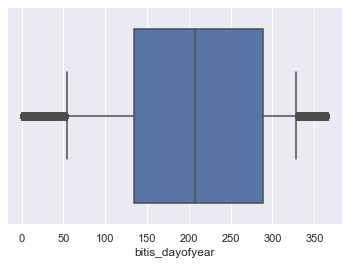

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


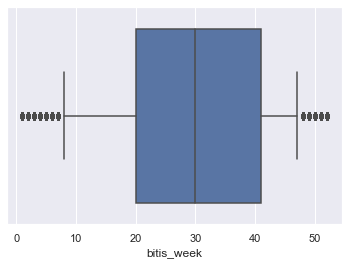

c:\Users\talha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


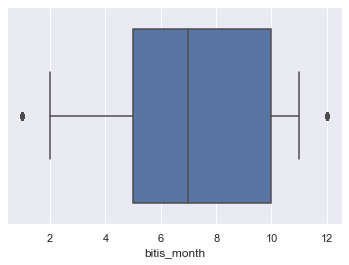

In [199]:
for col in num_cols:
    sns.boxplot(train[col],whis=[15,85])
    plt.show(block=True)

In [42]:
train = pd.get_dummies(train)

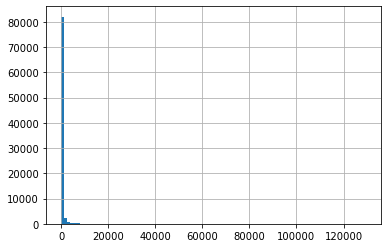

In [43]:
train["TOPLAM_KENTSEL_AG"].hist(bins=100)
plt.show()

<AxesSubplot:xlabel='KESİNTİ_SÜRESİ', ylabel='Count'>

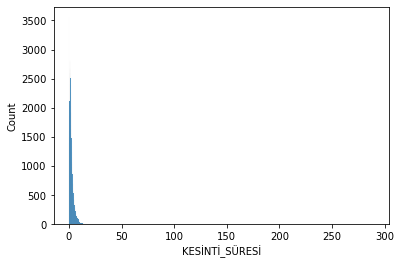

In [44]:
sns.histplot(data=train,x="KESİNTİ_SÜRESİ")

In [46]:
test["BAŞLAMA_TARİHİ_VE_ZAMANI"] = pd.to_datetime(test["BAŞLAMA_TARİHİ_VE_ZAMANI"],dayfirst=True)

In [53]:
test["BAŞLAMA_TARİHİ_VE_ZAMANI"].sort_values().head(20)

5032    2022-06-13 00:32:49
3946    2022-06-13 00:57:46
2909    2022-06-13 01:32:22
3085    2022-06-13 01:36:16
7491    2022-06-13 01:52:46
11519   2022-06-13 01:56:53
1902    2022-06-13 02:34:57
10811   2022-06-13 02:36:40
5842    2022-06-13 02:37:19
4411    2022-06-13 03:17:07
9294    2022-06-13 03:26:14
10356   2022-06-13 04:47:22
16719   2022-06-13 05:02:46
5210    2022-06-13 05:26:30
1680    2022-06-13 05:34:11
2232    2022-06-13 05:35:06
9155    2022-06-13 05:47:00
8488    2022-06-13 05:49:49
382     2022-06-13 06:05:48
12720   2022-06-13 06:06:21
Name: BAŞLAMA_TARİHİ_VE_ZAMANI, dtype: datetime64[ns]

In [56]:
test[["KESİNTİ_NO","BAŞLAMA_TARİHİ_VE_ZAMANI"]].head()

,KESİNTİ_NO,BAŞLAMA_TARİHİ_VE_ZAMANI
0,2342571,2022-07-09 22:49:22
1,2361468,2022-08-13 13:24:14
2,2361553,2022-08-13 16:44:49
3,2334266,2022-06-26 07:49:06
4,2366079,2022-08-21 17:12:03


In [ ]:
test['BAŞLAMA_TARİHİ_VE_ZAMANI'] = test['BAŞLAMA_TARİHİ_VE_ZAMANI'].apply(lambda x: x.replace(year = x.year - 1))

In [62]:
test["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.year.head()

0    2022
1    2022
2    2022
3    2022
4    2022
Name: BAŞLAMA_TARİHİ_VE_ZAMANI, dtype: int64

In [99]:
test_grup = test.groupby(pd.Grouper(key="BAŞLAMA_TARİHİ_VE_ZAMANI", freq="D"))["KENTSEL_OG"].sum()

In [100]:
test_grup = pd.DataFrame(test_grup).reset_index()

In [101]:
test_grup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   BAŞLAMA_TARİHİ_VE_ZAMANI  70 non-null     datetime64[ns]
 1   KENTSEL_OG                70 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.2 KB


In [102]:
train_grup = train[(train["BAŞLAMA_TARİHİ_VE_ZAMANI"] > "2021-06-13") & (train["BAŞLAMA_TARİHİ_VE_ZAMANI"] < "2021-08-22")]

In [103]:
train_grup.groupby(pd.Grouper(key="BAŞLAMA_TARİHİ_VE_ZAMANI", freq="D"))["KENTSEL_OG"].sum()

BAŞLAMA_TARİHİ_VE_ZAMANI
2021-06-13    3741
2021-06-14    5980
2021-06-15    3122
2021-06-16    2813
2021-06-17    1770
              ... 
2021-08-17    2541
2021-08-18    2318
2021-08-19    1431
2021-08-20     836
2021-08-21    1418
Freq: D, Name: KENTSEL_OG, Length: 70, dtype: int64

In [92]:
traint["TOPLAM_KENTSEL_AG"].mean()

379.1968293840487

In [106]:
test["TOPLAM_KENTSEL_AG"]

0         4.598333
1         0.000000
2         0.000000
3        79.886667
4         0.000000
           ...    
16746     2.783889
16747     0.000000
16748     0.000000
16749     5.108333
16750     0.000000
Name: TOPLAM_KENTSEL_AG, Length: 16751, dtype: float64

In [107]:
train_t = train_grup.sample(n = 16751)

<AxesSubplot:xlabel='BAŞLAMA_TARİHİ_VE_ZAMANI'>

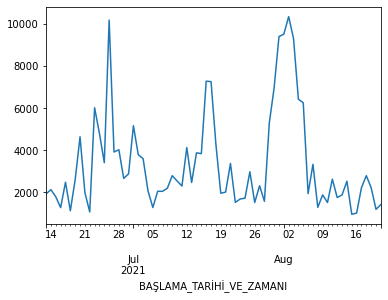

In [119]:
train_grup.groupby(pd.Grouper(key="BAŞLAMA_TARİHİ_VE_ZAMANI", freq="D"))["cagri_count"].sum().plot()

<AxesSubplot:>

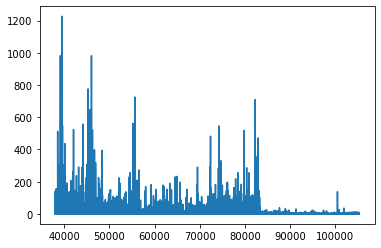

In [120]:
train_grup["cagri_count"].plot()

In [96]:
traint["BAŞLAMA_TARİHİ_VE_ZAMANI"]

37910    2021-06-20 11:27:33
37915    2021-08-07 20:47:00
37916    2021-07-21 15:20:44
37921    2021-07-24 16:26:14
37924    2021-06-21 15:05:32
                 ...        
105333   2021-08-18 23:25:40
105337   2021-06-21 16:17:00
105342   2021-07-03 18:45:36
105360   2021-06-24 14:46:33
105370   2021-07-12 09:39:51
Name: BAŞLAMA_TARİHİ_VE_ZAMANI, Length: 23682, dtype: datetime64[ns]

In [52]:
train.groupby(pd.Grouper(key="BAŞLAMA_TARİHİ_VE_ZAMANI", freq="D"))["KENTSEL_OG"].sum()

BAŞLAMA_TARİHİ_VE_ZAMANI
2021-05-01     875
2021-05-02     456
2021-05-03    1846
2021-05-04     728
2021-05-05     931
              ... 
2022-03-19    1317
2022-03-20    2265
2022-03-21    1490
2022-03-22     646
2022-03-23    1747
Freq: D, Name: KENTSEL_OG, Length: 327, dtype: int64

In [125]:
y = train["cagri_count"]
X = train.drop("cagri_count",axis=1)

In [174]:
#X = RobustScaler().fit_transform(X)
#X = pd.DataFrame(X)

In [126]:
X.head()

,KESİNTİ_SÜRESİ,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,...,ŞEBEKE_UNSURU_Saha Dağıtım Kutusu (SDK),ŞEBEKE_UNSURU_TM Fideri,KAYNAĞA_GÖRE_Dağıtım-AG,KAYNAĞA_GÖRE_Dağıtım-OG,KAYNAĞA_GÖRE_İletim,SÜREYE_GÖRE_Kısa,SÜREYE_GÖRE_Uzun,SEBEBE_GÖRE_Dışsal,SEBEBE_GÖRE_Güvenlik,SEBEBE_GÖRE_Şebeke işletmecisi
1,5.084444,3,1613,0,0,0,0,15.253333,8201.208888,0.0,...,0,0,0,1,0,0,1,0,0,1
2,1.729167,3,1613,0,0,0,0,5.187500,2789.145832,0.0,...,0,0,0,1,0,0,1,0,0,1
5,1.466111,14,15,0,0,0,0,20.525556,21.991667,0.0,...,0,0,0,1,0,0,1,0,0,1
13,1.099444,8,2752,0,0,0,0,8.795556,3025.671110,0.0,...,0,0,0,1,0,0,1,1,0,0
17,2.116389,1,40,0,0,0,0,2.116389,84.655556,0.0,...,0,0,0,1,0,0,1,0,0,1


In [188]:
def base_reg_models(X, y, scoring="neg_mean_squared_error"):
    print("Base Regression Models....")
    regressors = [('LR', LinearRegression()),
                  ("DT", DecisionTreeRegressor()),
                  ('GB', GradientBoostingRegressor(verbose=False)),
                  ('ADA', AdaBoostRegressor()),
                  ('XGB', XGBRegressor()),
                  ('LGBM', LGBMRegressor()),
                  ('CB', CatBoostRegressor(verbose=False))
                  ]

    for name, regressor in regressors:

        cv_result = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring=scoring)))

        print(f"{scoring}: {round(cv_result, 4)} ({name}) ")


base_reg_models(X, y)


#Base Regression Models....
#neg_mean_squared_error: 131.4927 (LR) 
#neg_mean_squared_error: 38.4812 (DT) 
#neg_mean_squared_error: 25.5298 (RF) 
#neg_mean_squared_error: 26.938 (GB) 
#neg_mean_squared_error: 117.4336 (ADA) 
#neg_mean_squared_error: 27.8393 (XGB) 
#neg_mean_squared_error: 25.5299 (LGBM) 
#neg_mean_squared_error: 25.7145 (CB) 

# ilcesiz robust
#
#neg_mean_squared_error: 74.2547 (LR) 
#neg_mean_squared_error: 38.8515 (DT) 
#neg_mean_squared_error: 25.8657 (RF) 
#neg_mean_squared_error: 26.9094 (GB) 
#neg_mean_squared_error: 90.4214 (ADA) 
#neg_mean_squared_error: 27.2804 (XGB) 
#neg_mean_squared_error: 25.5323 (LGBM) 
#neg_mean_squared_error: 25.4069 (CB) 


Base Regression Models....
neg_mean_squared_error: 25.3662 (LR) 
neg_mean_squared_error: 34.2786 (DT) 
neg_mean_squared_error: 24.4922 (GB) 
neg_mean_squared_error: 116.5323 (ADA) 
neg_mean_squared_error: 24.7628 (XGB) 
neg_mean_squared_error: 23.3318 (LGBM) 
neg_mean_squared_error: 22.8436 (CB) 


In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22)

xgb = XGBRegressor()
xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

# nisan öncesi 26.02156654
# ilcesiz 26.209088711991203
# ilcesiz robust 26.13611120821512
# ilcesiz nisanlı 22.510970156638695

22.510970156638695


In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22)
lgbm = LGBMRegressor()
lgbm.fit(X_train,y_train)

y_pred = lgbm.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
# base nisan öncesi 25.742758536057423
# ilcesiz 24.56702527927839
# ilcesiz robust 24.352886090166667
# ilcesiz nisanlı 21.67244299890845

21.67244299890845


In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22)
catboost = CatBoostRegressor()
catboost.fit(X_train,y_train,verbose=False)

y_pred = catboost.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

# base nisan öncesi 23.804272135207512
# ilcesiz 24.28086379730011
# ilcesiz robust 24.280825244392016
# ilcesiz nisanlı 20.986184475963626

24.28086379730011


In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22)
randomforest = RandomForestRegressor()
randomforest.fit(X_train,y_train)

y_pred = randomforest.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

22.206293728639835


In [129]:
def plot_importance(model, features, X, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 15))
    sns.set(font_scale=1)
    num = len(X)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


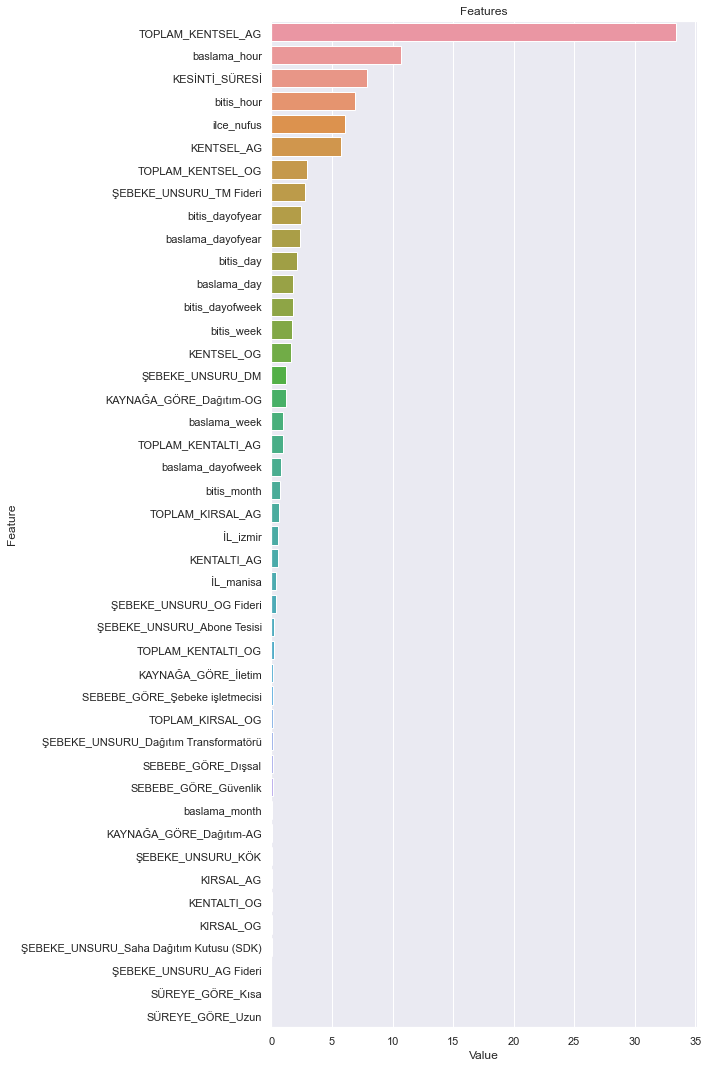

In [130]:
plot_importance(catboost,X_train,X_train)

<AxesSubplot:>

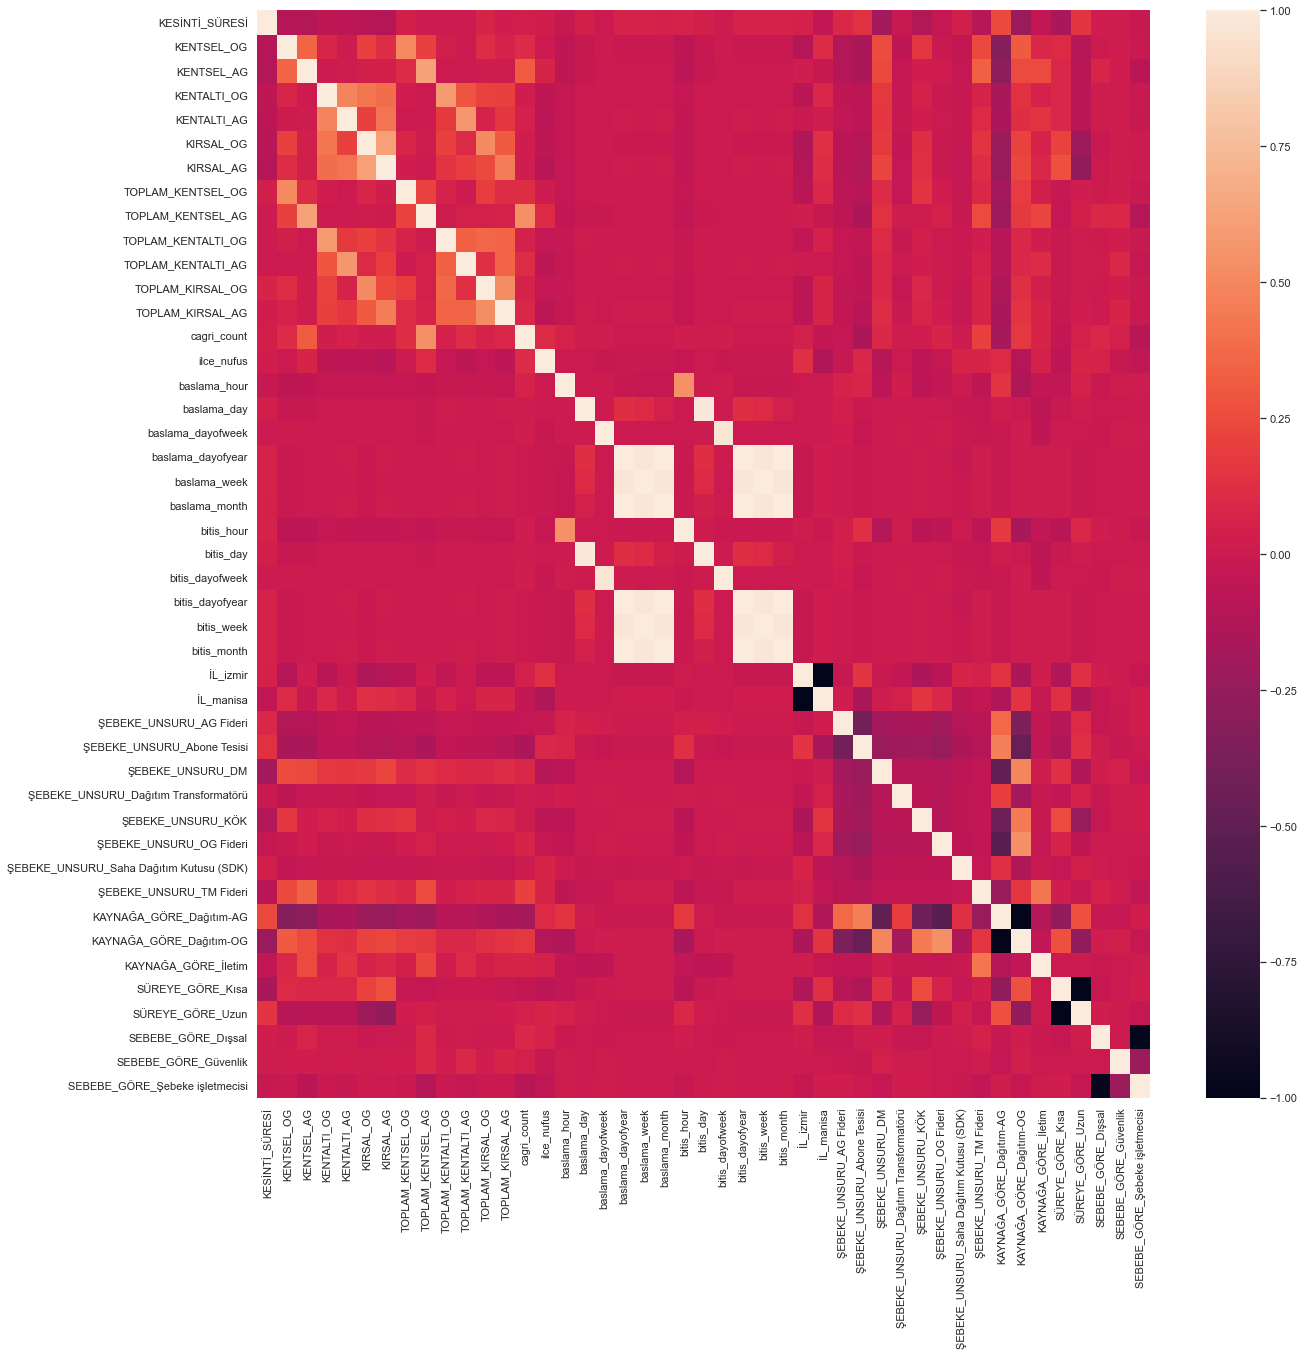

In [81]:
corr = train.corr()
fig,ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr)

In [189]:
#best lgbm
joblib.dump(lgbm,"ilcesiz_nisanli_lgbm_model.pkl")

['ilcesiz_nisanli_lgbm_model.pkl']

In [82]:
train["TOPLAM_KENTSEL_AG"].sort_values()

60808         0.000000
67935         0.000000
67934         0.000000
47849         0.000000
67933         0.000000
             ...      
46422     53268.183313
45318     56235.668329
55843     63178.828317
44755     65746.008143
40654    129419.169441
Name: TOPLAM_KENTSEL_AG, Length: 86268, dtype: float64

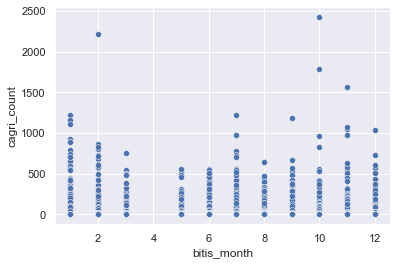

In [128]:
sns.scatterplot(data=train, x= "bitis_month", y= "cagri_count");

In [93]:
train.loc[(train["cagri_count"] > 2000) ,["TOPLAM_KENTSEL_AG","ilce_nufus","cagri_count"]]

,TOPLAM_KENTSEL_AG,ilce_nufus,cagri_count
2860,10062.680832,452.867,2223.0
83470,19476.578329,452.867,2431.0
